### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [1]:
# Select the API to use and load the benchmark program
api = "qiskit"
import hamlib_simulation_benchmark

# configure the QED-C Benchmark package for use with the given API
_, _ = hamlib_simulation_benchmark.qedc_benchmarks_init(api)

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 6
skip_qubits = 1
max_circuits = 1
num_shots = 1000

# Number of iterations performed with random initialization
iterations = 100

# Select the backend 
#backend_id = "qasm_simulator"
backend_id = "statevector_simulator"
provider_backend = None
exec_options = {}

#############

# place resulting data and images into a folder with "paper" suffix
import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 16

skip_execution = False


In [2]:
import numpy as np
import time
import os

# Configure module paths
import sys
sys.path.insert(1, "_common")
sys.path.insert(1, "qiskit")

sys.path.insert(1, "../_common/qiskit")
import execute

# Import HamLib helper functions (from _common)
import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
import hamlib_simulation_kernel

# Import Observable helper functions
import observables
import evolution_exact

#########  Configure a QASM simulator, possibly noisy
# backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

import sys
sys.path.insert(1, "../")

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model

# noisy, QV = 32 ...
#exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

#ideal ...
exec_options.update({ "noise_model": None })

# set up the execution target
execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
from new_functions import metrics_object



### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[ -1]     # just do a single Hamiltonian in this notebook

###########

# list of observable computation methods to sweep
# group_method_list = [ None, "simple", "N", "simple:wsd", "N:wsd", "estimator" ]
group_method_list = ["simple", "simple:wsd", "N", "N:wsd", ]

#group_method_list = [ None, "simple", "N" ]
#group_method_list = [ "estimator" ]

# these are ignored and set later in a loop
group_method = "N"
distribute_shots = False

print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")



*******************************************************************************************

Analyze Observable Computation Methods for chemistry/electronic/standard/H2 {'ham_BK': ''}



### Load the Given Hamiltonian to get its Pauli terms

In [4]:
# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


... dataset_name = ham_BK-6
... number of terms in Hamiltonian = 62



---
## Custom Functions used in this Notebook

### Arrange Pauli Terms into Commuting Groups
We show this here for information about the Hamiltonian being processed.

In [5]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, 1)

print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")
for group in pauli_term_groups:
    print(group)
        


... Number of terms in Hamiltonian: 62
... Number of groups created: 19

... Pauli Term Groups:
[('IIIIZI', (-0.2749555535474587+0j)), ('IIIIZZ', (-0.27495555354745865+0j)), ('IZIIII', (0.16462320552994025+0j)), ('IZZZII', (-0.15449737322433463+0j)), ('IIZIII', (-0.15449737322433463+0j)), ('ZZIIZI', (0.11328374063158088+0j)), ('ZIIIZZ', (0.11328374063158088+0j)), ('ZZZIII', (0.09615022483162383+0j)), ('ZZZZII', (0.09615022483162383+0j)), ('ZZIIZZ', (0.09204251930829206+0j)), ('ZIIIZI', (0.09204251930829206+0j)), ('IIIIIZ', (0.08994241004839341+0j)), ('IZIZII', (0.08366738652351666+0j)), ('ZIZIII', (0.08211612483661979+0j)), ('ZIZZII', (0.08211612483661979+0j)), ('IZZZZI', (0.08010765850263299+0j)), ('IIZIZZ', (0.08010765850263299+0j)), ('ZIIIII', (0.07702462857120082+0j)), ('ZZIIII', (0.07702462857120065+0j)), ('IZZZZZ', (0.07040296702925954+0j)), ('IIZIZI', (0.07040296702925954+0j)), ('IIIIII', (0.012171117706935006+0j))]
[('XYIYXX', (-0.03945860539424435+0j)), ('IYIYIX', (-0.0188383

### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [6]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit

def get_ansatz(num_qubits, params):
    ansatz = EfficientSU2(num_qubits).decompose()
    ansatz.barrier()

    params_dict = {p: params[i] for i, p in enumerate(ansatz.parameters)}

    # Use assign_parameters instead of bind_parameters
    ansatz = ansatz.assign_parameters(params_dict)
    
    return ansatz

# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)

# print(ansatz_circuit)


[ 0.307  1.352  0.646  0.282 -0.48   0.917 -0.392  2.462  2.913 -0.732
  1.833  0.182  0.428  2.674 -2.695 -2.594 -3.015  2.09   1.748  2.325
  3.007  1.88  -0.242  1.763 -2.398  0.879 -2.241  2.794  0.137 -0.536
 -1.479  1.723 -0.276  0.43  -3.024  0.739  0.704  0.735  2.788  1.142
 -0.883 -0.396  1.242 -2.763  1.048  1.072 -1.82  -2.332]


### Generate Random Initialization States
Here we generate initialization states using a bitstring containing 0s and 1s only.

In [7]:
import random

def generate_random_int_and_bitstring(num_qubits):
    """
    Generates a random bitstring representing an integer from 0 to N-1,
    given a number of qubits exponentiated where N is a power of 2.

    Args:
        num_qubits (int): number of qubits for which to generate random int state.

    Returns:
        str: A random bitstring representation of an integer in range [0, N-1].
    """

    N = 2 ** num_qubits
    
    if N <= 0 or (N & (N - 1)) != 0:
        raise ValueError("N must be a power of 2.")

    num_bits = N.bit_length() - 1  # Determine the number of bits needed
    random_number = random.randint(0, N - 1)  # Pick a random number in range [0, N-1]
    
    return random_number, format(random_number, f'0{num_bits}b')  # Convert to bitstring with leading zeros


### Custom Observable Estimation Function
This function wraps the four steps of the process into a single function.

In [8]:
from new_functions import create_measurement_circuts, do_execute, compute_energy
from new_functions import compute_exact_value

def estimate_expectation_value_top(num_qubits, sparse_pauli_terms, group_method, num_shots, initial_circuit, metrics_object):
    ts = time.time()

    ######### Use Qiskit Estimator
    if group_method == "estimator":

        # create Trotterized evolution circuit for HamLib Hamiltonian
        ts = time.time()
        qc, _ = hamlib_simulation_kernel.HamiltonianSimulation(
            num_qubits=num_qubits, 
            #ham_op=sparse_pauli_terms,
            K = 0, t = 0.0,
#             init_state = init_state,
            append_measurements = False,
            method = 1, 
            initial_circuit = initial_circuit,
        )
    
        create_time = round(time.time()-ts, 3)
        metrics_object["create_base_time"] = create_time
        #print(f"\n... finished creating base circuit, total creation time = {create_time} sec.\n")
    
        #print(qc)
            
        # Ensure that the pauli_terms are in 'full' format, not 'sparse' - convert if necessary
        pauli_terms = observables.ensure_pauli_terms(sparse_pauli_terms, num_qubits=num_qubits)
        pauli_terms = observables.swap_pauli_list(pauli_terms)
        
        estimator_energy = observables.estimate_expectation_with_estimator(execute.backend, qc, pauli_terms,
                                                            num_shots=num_shots, noise_model=execute.noise)

        obs_time = round(time.time()-ts, 3)
        metrics_object["observable_compute_time"] = obs_time
        
        metrics_object["grouping_time"] = 0.0
        #metrics_object["create_base_time"] = 0.0
        metrics_object["append_measurements_time"] = 0.0
        metrics_object["execute_circuits_time"] = 0.0
    
        return estimator_energy

    ######### Group Commuting Terms

    # Arrange the Pauli terms into commuting groups based on group_method
    
    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)

    grouping_time = round(time.time()-ts, 3)
    metrics_object["grouping_time"] = grouping_time
    #print(f"\n... finished grouping of terms, total grouping time = {grouping_time} sec.\n")
    
    ######### Create Base Circuit
    
    # create Trotterized evolution circuit for HamLib Hamiltonian
    ts = time.time()
    qc, _ = hamlib_simulation_kernel.HamiltonianSimulation(
        num_qubits=num_qubits, 
        #ham_op=sparse_pauli_terms,
        K = 0, t = 0.0,
#         init_state = init_state,
        append_measurements = False,
        method = 1, 
        initial_circuit = initial_circuit,
    )

    create_time = round(time.time()-ts, 3)
    metrics_object["create_base_time"] = create_time
    #print(f"\n... finished creating base circuit, total creation time = {create_time} sec.\n")

    #print(qc)

    ######### Append Measurement Circuits
    
    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list, use_diag_method, num_k)

    #for c in circuits:
    #    print(c)

    ######### Execution
    
    results, pauli_term_groups = do_execute(backend_id, circuits, num_shots, pauli_term_groups, distribute_shots)

    ######### Compute Energy
    
    energy = compute_energy(num_qubits, results, pauli_term_groups, group_method, num_k)
    energy = np.real(energy)

    return energy


### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


In [9]:
from qiskit_aer import Aer

def do_random_state_loop():

    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")

    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
        
    # create arrays to hold metrics
    init_values = []
    exact_energies = []
    computed_energies = []
    metrics_array = []
    from new_functions import initialize_metrics_row

    print("")
    
    # For each iteration, generate random input, compute observable, and store data
    for it in range(iterations):
        
        #reset the metrics object
        metrics_object = initialize_metrics_row()
    
        ######### Initialize
        """
        # Create a quantum ansatz circuit with the given parameters (update later to use Parameter)
        qc = get_ansatz(num_qubits, params)  
        #print(qc)
        """
#         init_value, init_state = generate_random_int_and_bitstring(num_qubits)
#         init_values.append(init_value)
        ansatz = EfficientSU2(num_qubits)

        num_params = ansatz.num_parameters

        # Generate initial parameters with correct length
        initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
        initial_qc = get_ansatz(num_qubits, initial_params)
    
        ######### Compute Exact Energy
        backend = Aer.get_backend('statevector_simulator')
        init_state = backend.run(initial_qc).result().get_statevector().data
        exact_energy = compute_exact_value(num_qubits, init_state, sparse_pauli_terms)
        exact_energies.append(exact_energy)
    
        ######### Estimate Energy using Quantum Algorithm
        
        # estimate expectation using the benchmark functions
        energy = estimate_expectation_value_top(num_qubits, sparse_pauli_terms, group_method, num_shots, initial_qc, metrics_object)   
        computed_energies.append(energy)
    
        # Append metrics from this iteration to the array of metrics
        metrics_array.append(metrics_object)

        print(".", end='')

    print("")

    return init_values, exact_energies, computed_energies, metrics_array


---
## Observable Estimation Loop for Analysis
Here we compute an observable (energy) for the given Hamiltonian, sweeping over the specified set of group methods.  Using the value and timing analysis plots, this provides a means to compare the behavior of these methods.



Testing expectation grouping method: simple


Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
... executing on num_qubits = 6, shots = 1000
    grouping method = simple, use_diag_method = False, num_k = 1
    number of terms in Hamiltonian = 62, number of groups created = 19

....................................................................................................
done


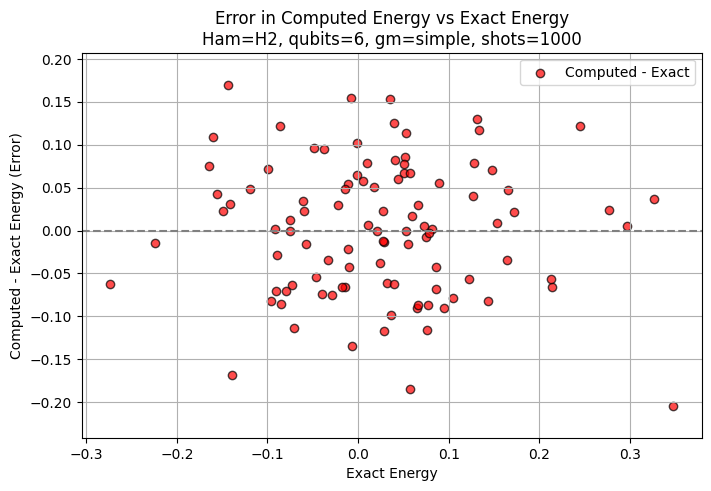

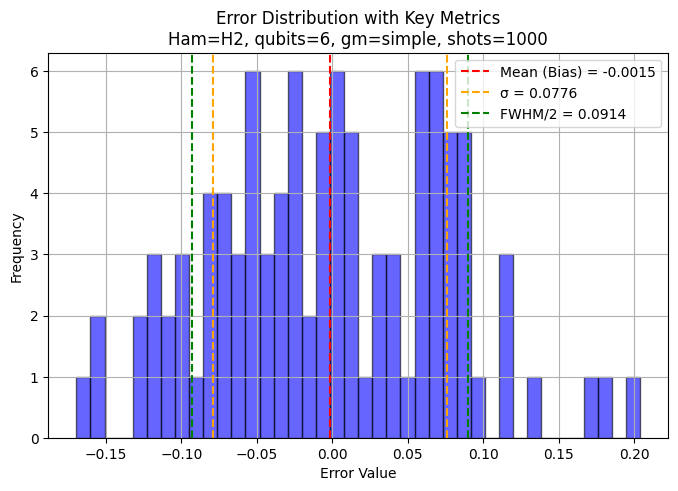


🔹 **Bias Detection**
Mean Error (Bias) = -0.0015
✅ No significant bias detected.


Testing expectation grouping method: simple


Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
... executing on num_qubits = 6, shots = 1000
    grouping method = simple, use_diag_method = False, num_k = 1
    number of terms in Hamiltonian = 62, number of groups created = 19

shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot allocation: [7, 109, 354, 0, 7, 123, 1, 0, 0, 0, 7, 2, 38, 0, 0, 0, 7, 345, 0]
.shot all

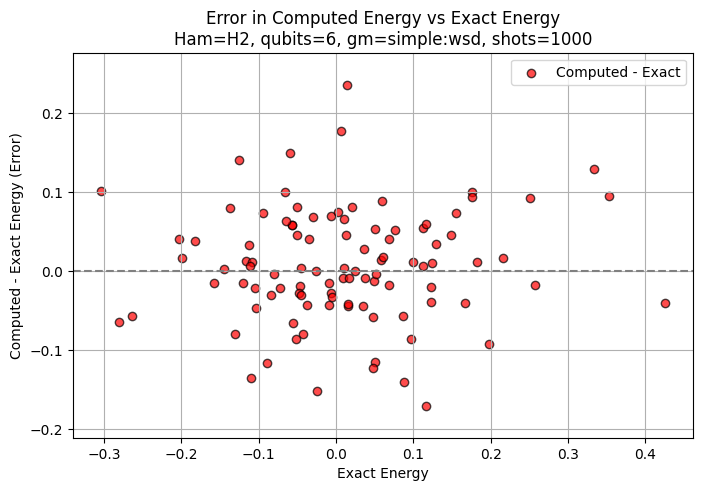

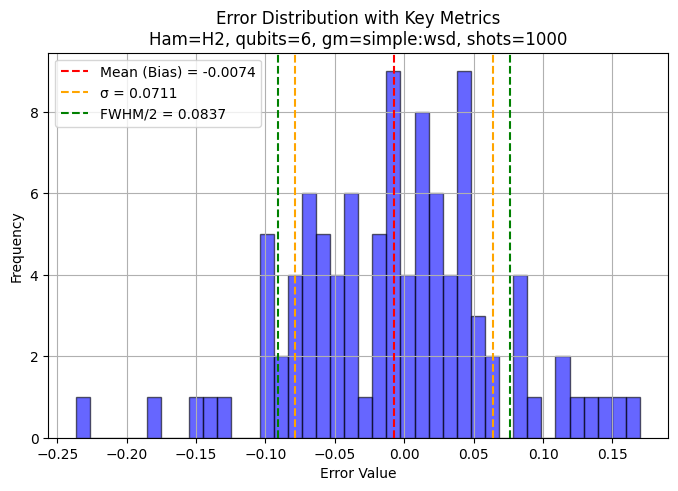


🔹 **Bias Detection**
Mean Error (Bias) = -0.0074
✅ No significant bias detected.


Testing expectation grouping method: N


Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
... executing on num_qubits = 6, shots = 1000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 62, number of groups created = 7

....................................................................................................
done


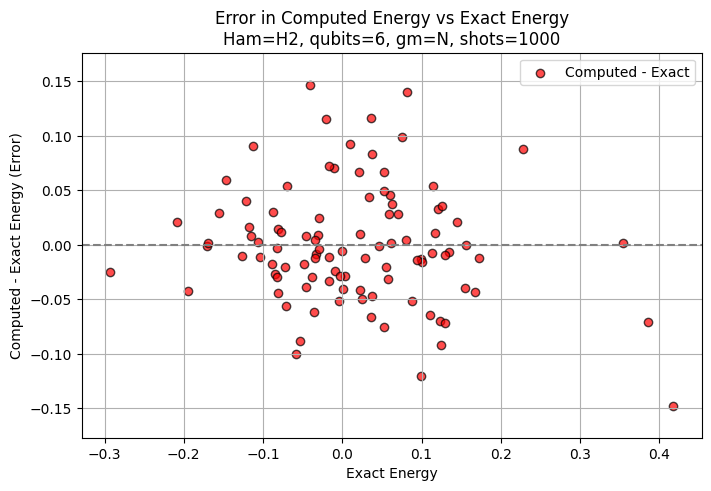

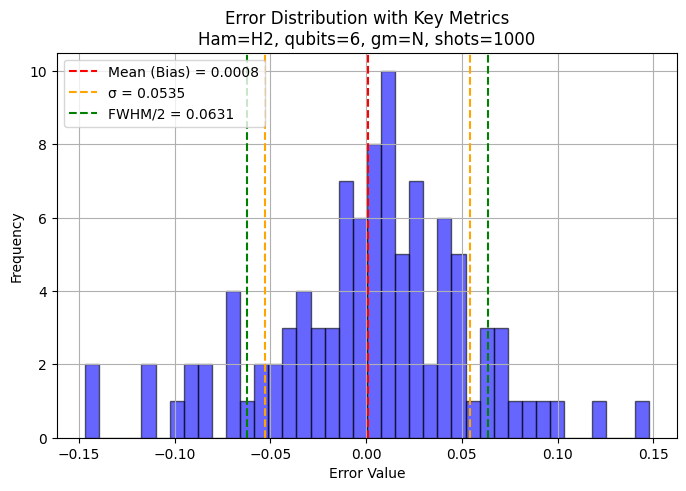


🔹 **Bias Detection**
Mean Error (Bias) = 0.0008
✅ No significant bias detected.


Testing expectation grouping method: N


Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
... executing on num_qubits = 6, shots = 1000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 62, number of groups created = 7

shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocation: [973, 19, 5, 2, 1, 0, 0]
.shot allocatio

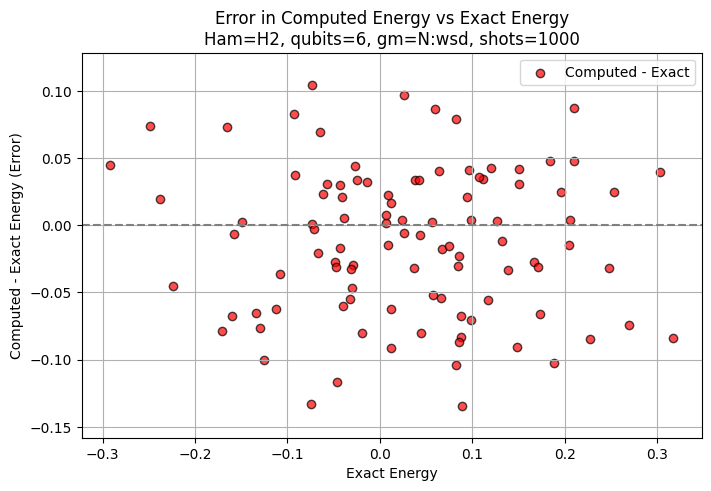

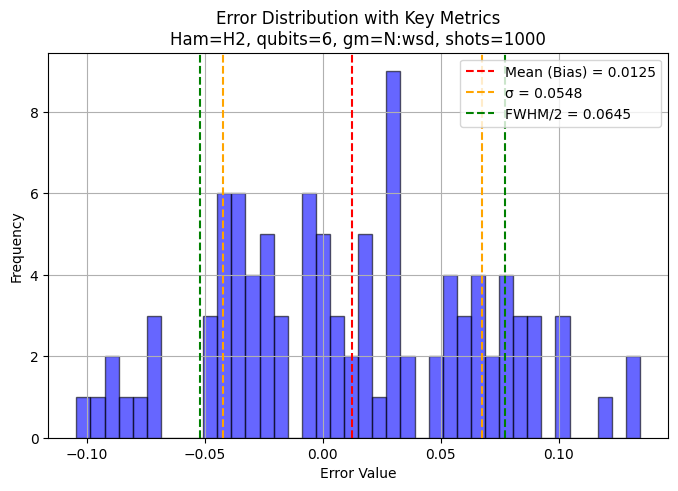


🔹 **Bias Detection**
Mean Error (Bias) = 0.0125
✅ No significant bias detected.


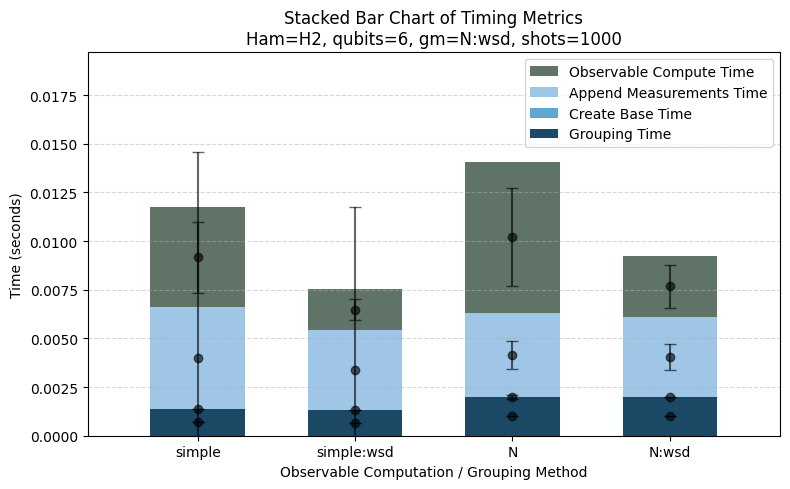

In [10]:
from metric_plots import plot_value_analysis_data

from new_functions import compute_timing_stats
from metric_plots import plot_timing_analysis_bar_chart

timing_datasets = []
timing_dataset_labels = []
    
for group_method_label in group_method_list:
    global use_diag_method, num_k
    global distribute_shots

    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False
  
    if group_method == "N":
        use_diag_method = True
        num_k = num_qubits
    else:
        use_diag_method = False
        num_k = 1

    print("\n============================================================\n")
    print(f"Testing expectation grouping method: {group_method}\n") 

    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop()
    print("done")

    # Generate the value anlysis plots
    plot_value_analysis_data(
            hamiltonian_name,
            backend_id,
            num_qubits,
            group_method_label,
            num_shots,
            init_values, 
            exact_energies,
            computed_energies
        )

    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })

#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_label,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

# Version 2: Error bars at the top of the bars
#plot_timing_analysis_bar_chart(datasets, dataset_labels, error_bar_position="top")


### Generate Timing Analysis Plot from Existing Data
We will enhance this reproduce the plots from data stored in files.

However, currently this just uses the data in memory.

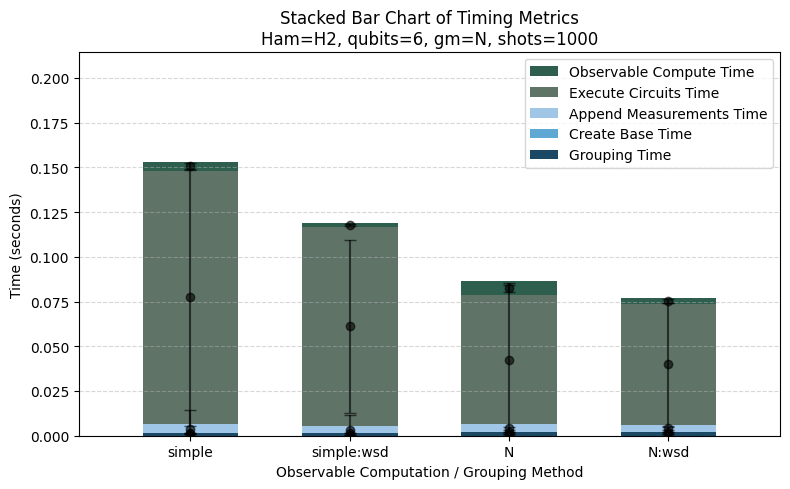

In [11]:

# print(timing_datasets)
# print(timing_dataset_labels)

categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

# Version 2: Error bars at the top of the bars
#plot_timing_analysis_bar_chart(datasets, dataset_labels, error_bar_position="top")
